## Исследование поведения пользователей мобильного приложения

Необходимо:
- Выявить путь пользователя;
- Изучите воронку событий;
- Обработать результаты A/A/B-эксперимента изменения шрифтов;

[Подготовка данных.](#preparation)
 - [Описание данных](#description)
 - [Приведение данных в порядок](#data_adaptation)
 - [Резюмирование проделанного](#little_conclusion)

[Изучение данных.](#analyze)

[Изучение воронки данных.](#funnel)

[Изучение результатов эксперимента.](#res_exp)
 - [Проверка соотношения долей пользователей по различным действиям в двух контрольных группах](#gr12)
 - [Проверка соотношения долей пользователей по различным действиям в экспериментальной группе и первой контрольной](#gr1exp)
 - [Проверка соотношения долей пользователей по различным действиям в экспериментальной группе и второй контрольной](#gr2exp)
 - [Проверка соотношения долей пользователей по различным действиям в экспериментальной группе и объединённой  контрольной группе](#gr12exp)
 - [Вывод о результатах экспериментов](#conclusion_res)

[Общий вывод](#conclusion)

## Подготовка данных. <a name='preparation'></a>

In [1]:
%%capture
!pip install plotly -U

from plotly import graph_objects as go
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import datetime 
import math
from scipy import stats 
sns.set_palette('pastel') 
pd.options.mode.chained_assignment = None

In [2]:
action_user_df = pd.read_csv('/datasets/logs_exp.csv', sep='\t')
action_user_df.info()
action_user_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
EventName         244126 non-null object
DeviceIDHash      244126 non-null int64
EventTimestamp    244126 non-null int64
ExpId             244126 non-null int64
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


### Описание данных<a name='description'></a>

Каждая запись в логе — это действие пользователя, или событие.
- EventName — название события;
- DeviceIDHash — уникальный идентификатор пользователя;
- EventTimestamp — время события;
- ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

In [3]:
primary_set_peoples_in_gr = action_user_df.groupby('ExpId')['DeviceIDHash'].nunique().values

### Приведение данных в порядок <a name='data_adaptation'></a>


In [4]:
action_user_df.rename(columns={"EventName": "appear_screens", "DeviceIDHash": "hash_device_id",
                               "EventTimestamp": "event_timestamp", "ExpId": "exp_id"}, inplace=True)
print(f'{action_user_df.duplicated().sum()} - количество дубликатов')
print(action_user_df.loc[action_user_df.duplicated()]['appear_screens'].value_counts())
action_user_df.drop_duplicates(inplace=True)

413 - количество дубликатов
PaymentScreenSuccessful    195
MainScreenAppear           104
CartScreenAppear            63
Tutorial                    34
OffersScreenAppear          17
Name: appear_screens, dtype: int64


In [5]:
action_user_df['exp_id'] = action_user_df['exp_id'].replace({246: 'КГ 1', 247: 'КГ 2', 248: 'ЭГ'})
action_user_df['appear_screens'] = action_user_df['appear_screens'].replace({'MainScreenAppear': 'Main',
    'OffersScreenAppear': 'Offers', 'CartScreenAppear': 'Cart', 'PaymentScreenSuccessful': 'Payment successful'})

action_user_df['date_event'] = pd.to_datetime(action_user_df['event_timestamp'], unit='s').astype(dtype='datetime64[D]')
action_user_df['time_event'] = pd.to_datetime(action_user_df['event_timestamp'], unit='s')
action_user_df.drop(['event_timestamp'], axis=1, inplace=True)
action_user_df.info()
action_user_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 5 columns):
appear_screens    243713 non-null object
hash_device_id    243713 non-null int64
exp_id            243713 non-null object
date_event        243713 non-null datetime64[ns]
time_event        243713 non-null datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(2)
memory usage: 11.2+ MB


,appear_screens,hash_device_id,exp_id,date_event,time_event
0,Main,4575588528974610257,КГ 1,2019-07-25,2019-07-25 04:43:36
1,Main,7416695313311560658,КГ 1,2019-07-25,2019-07-25 11:11:42
2,Payment successful,3518123091307005509,ЭГ,2019-07-25,2019-07-25 11:28:47
3,Cart,3518123091307005509,ЭГ,2019-07-25,2019-07-25 11:28:47
4,Payment successful,6217807653094995999,ЭГ,2019-07-25,2019-07-25 11:48:42


### Резюмирование проделанного <a name = 'little_conclusion'></a>

* Удалён неинформативный столбец с timestamp'ами;
* Созданы столбцы даты и даты со временем;
* В столбце с действиями описываются появление различных экранов, в связи с чем переименовал столбец, поменял появление различных экранов на название конкретных экранов;
* Заменены номерa групп на более информативные КГ 1 (246), КГ 2 (247), ЭГ (248), где К - контрольная, Э - экспериментальная, Г - группа;
* Какой-то закономерности в событиях, у которых есть дубликаты не выявлено, 413 дубликатов удалено, возможными причинами их появления считаю:
   * Некорректная работа приложения;
   * Многократные попытки пользователем совершить одно и тоже действие, например по причине зависания приложения; 
   * Иные технические ошибки.

## Изучение данных. <a name ='analyze'></a>


In [6]:
print('{} - количество различных событий'.format(action_user_df['appear_screens'].nunique()))
print('{} - количество различных пользователей'.format(action_user_df['hash_device_id'].nunique()))
print('{:.2f} - среднее число событий на пользователя'.format(action_user_df.
                                                              groupby('hash_device_id')['appear_screens'].count().mean()))
print('{} - самая ранняя дата {} - самая поздняя дата'.
      format(action_user_df['date_event'].min().date(), action_user_df['date_event'].max().date()))


5 - количество различных событий
7551 - количество различных пользователей
32.28 - среднее число событий на пользователя
2019-07-25 - самая ранняя дата 2019-08-07 - самая поздняя дата


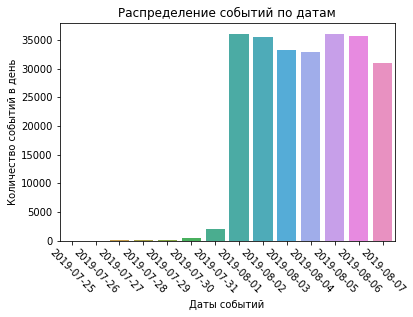

In [7]:
data_for_hist = action_user_df['date_event'].value_counts().reset_index().sort_values('index', ascending=True)
data_for_hist['index'] = data_for_hist['index'].dt.strftime('%Y-%m-%d')
ax = sns.barplot(x="index", y="date_event", data = data_for_hist)
ax.set_xlabel("Даты событий")
ax.set_title("Распределение событий по датам")
ax.set_ylabel("Количество событий в день")
ax.set_xticklabels(ax.get_xticklabels(), rotation=-45);

Колоссальное отличие в данных за различные даты, в связи с чем далее будем считать границей свежести - второе августа.

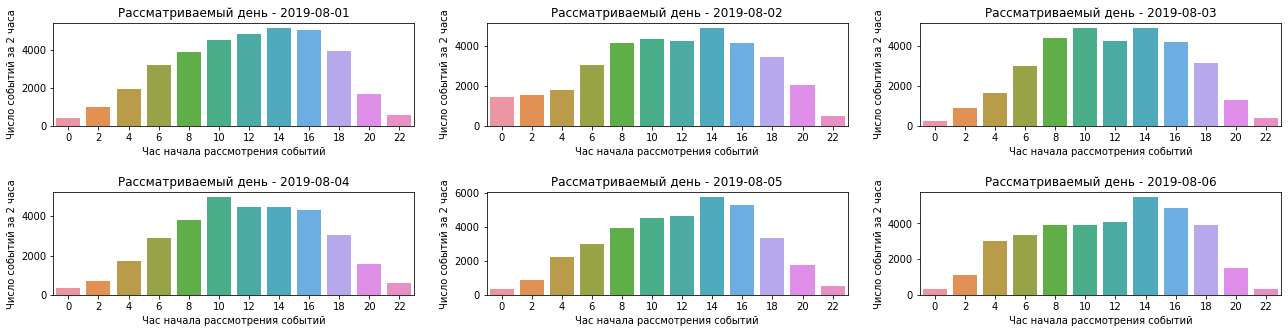

In [8]:
# Выделение четного часа события
action_user_df['even_hours'] = action_user_df['time_event'] \
            .apply(lambda dt: datetime.datetime(dt.year, dt.month, dt.day, 2 * (dt.hour // 2)))

# Получение информации о событиях за шесть дней из последней недели, выявление часа, даты события 
hist_by_even_hours = action_user_df.query('date_event >= "2019-08-01" and date_event != "2019-08-07"') \
                        ['even_hours'].value_counts().reset_index()
hist_by_even_hours['date'] = hist_by_even_hours['index'].dt.date
hist_by_even_hours['index'] = hist_by_even_hours['index'].dt.hour
hist_by_even_hours = hist_by_even_hours.sort_values('date', ascending=True)

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(22,5))
plt.subplots_adjust(hspace = 0.65)

# Построение гистограмм распределений событий по часам за шесть дней из крайней недели 
for counter_day in range(hist_by_even_hours['date'].nunique()):
    considered_date = hist_by_even_hours['date'].unique()[counter_day]
    sns.barplot(ax = axs[counter_day // 3, counter_day % 3], x="index", y="even_hours", 
                data=hist_by_even_hours.query('date == @considered_date').sort_values('index', ascending=True))
    
    axs[counter_day // 3, counter_day % 3].set_title(f'Рассматриваемый день - {considered_date}')
    axs[counter_day // 3, counter_day % 3].set_ylabel(f'Число событий за 2 часа')
    axs[counter_day // 3, counter_day % 3].set_xlabel(f'Час начала рассмотрения событий')

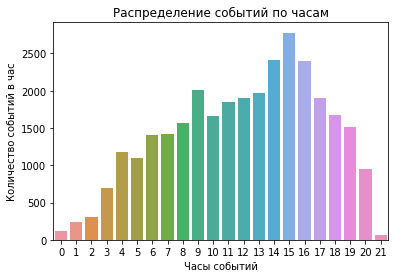

In [9]:
# Получение информации о событиях в крайний день 
info_last_day = action_user_df.query('date_event == "2019-08-07"')
info_last_day['hour_event'] = info_last_day['time_event'].dt.hour
info_last_day = info_last_day['hour_event'].value_counts().reset_index().sort_values('index', ascending = True)

ax = sns.barplot(x="index", y="hour_event", data = info_last_day)
ax.set_xlabel("Часы событий")
ax.set_title("Распределение событий по часам")
ax.set_ylabel("Количество событий в час");

In [10]:
print(len(action_user_df) - len(action_user_df.query('date_event >= "2019-08-01"')), '- Число потерянных событий')
print(action_user_df['hash_device_id'].nunique() - 
      action_user_df.query('date_event >= "2019-08-01"')['hash_device_id'].nunique(), '- Число потерянных пользователей')

print(action_user_df.query('date_event >= "2019-08-01"')['exp_id'].value_counts(), ' Число пользователей по группам')
print(action_user_df['exp_id'].value_counts() - action_user_df.query('date_event >= "2019-08-01"')['exp_id'].value_counts())
print('Количество удаленных пользователей из каждой группы.')
action_user_df = action_user_df.query('date_event >= "2019-08-01"')

2826 - Число потерянных событий
17 - Число потерянных пользователей
ЭГ      84563
КГ 1    79302
КГ 2    77022
Name: exp_id, dtype: int64  Число пользователей по группам
ЭГ      1019
КГ 1     879
КГ 2     928
Name: exp_id, dtype: int64
Количество удаленных пользователей из каждой группы.


### Вывод:
* 5 - количество различных видов событий, число событий всего равно числу строк 243713;
* 7551 - количество различных пользователей до актуализации временного промежутка;
* 32.28 - среднее число событий на пользователя;
* Минимальная доступная дата - 2019-07-25, самая поздняя - 2019-08-07;
* С первого по седьмое августа число событий стабильно высокое 30000 - 35000;
* Распределение числа событий внутри дня последнего времени похожи между собой с пиком в районе 14 часов;
* По данным последнего дня неизвестны часть данных с 21 часа и позднее, в связи с чем и последний день возможно рассматривать далее, лишь делая поправку на это;
* Потеряны лишь 2826 устаревших событий, это около одного процента от общего их числа и 17 пользователей 0.23% от всех пользователей;
* Имеются представители всех трёх экспериментальных групп, при этом число удаленных пользователей из каждой группы примерно равны.

## Изучение воронки данных <a name='funnel'></a>


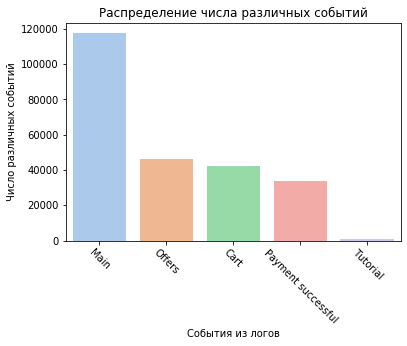

In [11]:
ax = sns.barplot(x="index", y="appear_screens", data = action_user_df['appear_screens'].value_counts().reset_index())
ax.set_xlabel("События из логов")
ax.set_title("Распределение числа различных событий")
ax.set_ylabel("Число различных событий")
ax.set_xticklabels(ax.get_xticklabels(), rotation=-45);

Посчитайте, сколько пользователей совершали каждое из этих событий. Отсортируйте события по числу пользователей. Посчитайте долю пользователей, которые хоть раз совершали событие.


466 - количество пользователей, увидевшие все экраны


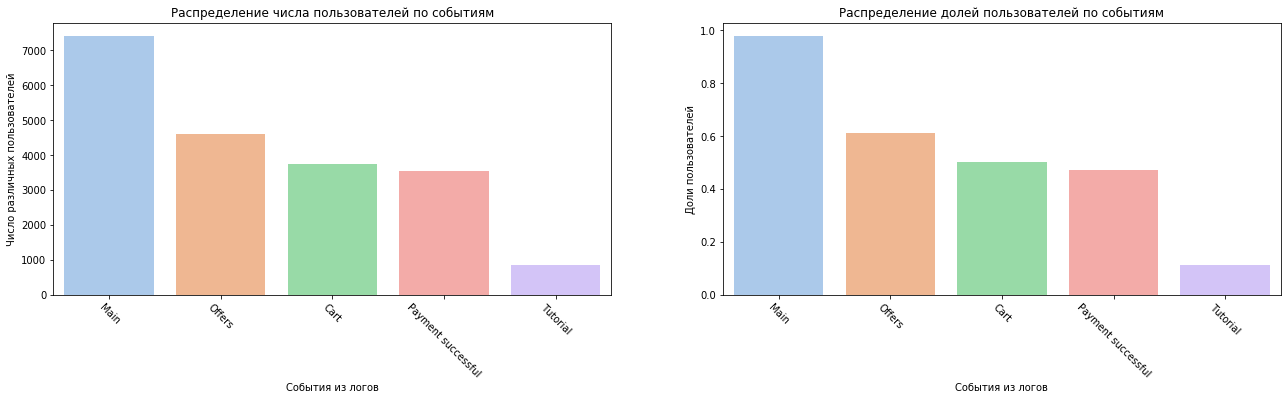

In [12]:
funnel_df = action_user_df.groupby('hash_device_id')['appear_screens'].nunique().reset_index()
print('{} - количество пользователей, увидевшие все экраны'.format(funnel_df.query('appear_screens == 5').count().values[0]))

actions_by_users = action_user_df. \
            groupby('appear_screens')['hash_device_id'].nunique().reset_index().sort_values('hash_device_id', ascending=False)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(22,5))
sns.barplot(ax = axs[0], x="appear_screens", y="hash_device_id", data = actions_by_users)
axs[0].set_xlabel("События из логов")
axs[0].set_title("Распределение числа пользователей по событиям")
axs[0].set_ylabel("Число различных пользователей")
axs[0].set_xticklabels(ax.get_xticklabels(), rotation=-45);


actions_by_users['proportion_action'] =  round(actions_by_users['hash_device_id'] /
                                               action_user_df['hash_device_id'].nunique(), 2)
sns.barplot(ax = axs[1], x="appear_screens", y="proportion_action", 
                data=actions_by_users)
axs[1].set_xlabel("События из логов")
axs[1].set_title("Распределение долей пользователей по событиям")
axs[1].set_ylabel("Доли пользователей")
axs[1].set_xticklabels(ax.get_xticklabels(), rotation=-45);

Последовательностью событий будем считать следующее: Главный экран, предложение, корзина, сообщение об успешной покупке.

Сложно предположить о популярных последовательностях действий, но есть следующие соображения:
* Часто первым событием может являться - главный экран;
* В некоторых случаях пользователи перед оплатой оказываются в корзине;
* После главной страницы пользователям могут быть интересны предложения;
* Возможно существуют много пользователей, которые просто открывают приложение и оказываются лишь на одной странице и всё.

Найдём популярные последовательности событий, но обозначу пару допущений:
* Будем рассматривать последовательность действий без ограничения по времени, не обращая внимание на временные промежутки между событиями;
* Будем обращать внимание только на первое событие каждого вида.  

In [13]:
# Получение последовательности событий для пользователя
def get_sequence_actions(arr_actions):
    list_sequence = list()
    for element in arr_actions:
        if element not in list_sequence:
            list_sequence.append(element)
        
        if len(list_sequence) == 5:
            break;
            
    return str(list_sequence)[1:-1]
    
# Получение словаря последовательностей событий и частоты их встречаемости
def get_top_sequence(df):
    dict_sequences = {}
    
    for id_device in df['hash_device_id'].unique():
        result_functions = get_sequence_actions(action_user_df.query('hash_device_id == @id_device')
                                                .sort_values('time_event')['appear_screens'].values)
        
        if result_functions in dict_sequences:
            dict_sequences[result_functions] += 1
        else:
            dict_sequences[result_functions] = 1 

    return dict_sequences
    
dict_seq = get_top_sequence(action_user_df)
dict_seq = { key:value for (key,value) in dict_seq.items() if value > action_user_df['hash_device_id'].nunique() * 0.05}
{key: value for key, value in sorted(dict_seq.items(), key=lambda dict_seq: dict_seq[1], reverse=True)}

{"'Main'": 2701,
 "'Main', 'Offers'": 760,
 "'Main', 'Offers', 'Payment successful', 'Cart'": 712,
 "'Main', 'Payment successful', 'Cart', 'Offers'": 655,
 "'Main', 'Offers', 'Cart', 'Payment successful'": 646,
 "'Main', 'Cart', 'Payment successful', 'Offers'": 473}

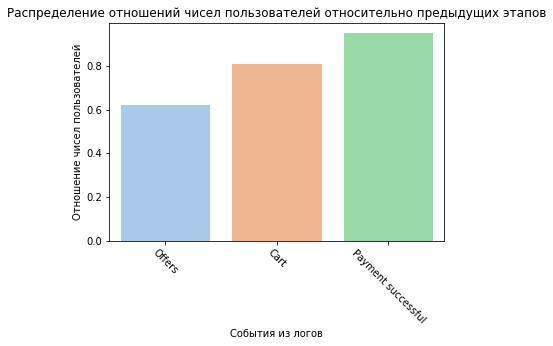

In [14]:
actions_by_users.reset_index(drop = True, inplace = True)

for counter in range(1,4):
    actions_by_users.loc[counter, 'from_last'] = round(actions_by_users.loc[counter, 'hash_device_id'] /
                                                       actions_by_users.loc[counter-1, 'hash_device_id'], 2)
    
ax = sns.barplot(x="appear_screens", y="from_last", data = actions_by_users.loc[1:3])
ax.set_xlabel("События из логов")
ax.set_title("Распределение отношений чисел пользователей относительно предыдущих этапов")
ax.set_ylabel("Отношение чисел пользователей")
ax.set_xticklabels(ax.get_xticklabels(), rotation=-45);

0.48 -  доля пользователей, которая доходит от первого события до оплаты


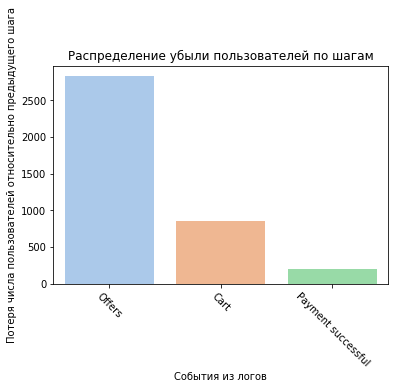

In [15]:
for counter in range(1,4):
    actions_by_users.loc[counter, 'difference_peoples'] = actions_by_users.loc[counter-1, 'hash_device_id'] - \
        actions_by_users.loc[counter, 'hash_device_id']


ax = sns.barplot(x="appear_screens", y="difference_peoples", data = actions_by_users.loc[1:3])
ax.set_xlabel("События из логов")
ax.set_title("Распределение убыли пользователей по шагам")
ax.set_ylabel("Потеря числа пользователей относительно предыдущего шага")
ax.set_xticklabels(ax.get_xticklabels(), rotation=-45);
print('{:.2f} -  доля пользователей, которая доходит от первого события до оплаты'.
      format(actions_by_users.loc[3,'hash_device_id'] / actions_by_users.loc[0,'hash_device_id']))

In [16]:
control_group1 = action_user_df.query('exp_id == "КГ 1"')
control_group2 = action_user_df.query('exp_id == "КГ 2"')
experiment_group = action_user_df.query('exp_id == "ЭГ"')

aggr_control_group1 = control_group1.groupby('appear_screens')['hash_device_id'].nunique(). \
            sort_values(ascending=False)
aggr_control_group2 = control_group2.groupby('appear_screens')['hash_device_id'].nunique(). \
            sort_values(ascending=False)
aggr_experiment_group = experiment_group.groupby('appear_screens')['hash_device_id'].nunique(). \
            sort_values(ascending=False)

In [29]:
fig = go.Figure()

fig.add_trace(go.Funnel(
    name = 'Экспериментальная группа',
    y = aggr_experiment_group[:-1].index,
    x = aggr_experiment_group[:-1].values,
    textinfo = "value+percent initial"))

fig.add_trace(go.Funnel(
    name = 'Контрольная группа 1',
    orientation = "h",
    y = aggr_control_group1[:-1].index,
    x = aggr_control_group1[:-1].values,
    textposition = "inside",
    textinfo = "value+percent previous"))

fig.add_trace(go.Funnel(
    name = 'Контрольная группа 2',
    orientation = "h",
    y = aggr_control_group2[:-1].index,
    x = aggr_control_group2[:-1].values,
    textposition = "inside",
    textinfo = "value+percent total"))

fig.show()

### Вывод о воронках:

* Рассматриваемая воронка является несвязанной, так как оплату - конечное действие пользователи производят со всех экранов;
* Всего в логах 5 событий, 1 из которых является опциональным, и используется небольшим числом пользователей;
* Наибольшее число пользователей теряется при переходе от главного экрана к окну предложений, что может говорить о недовольстве дизайном - функционалом, который встречает пользователей;
* 48 процентов пользователей от главного экрана доходят до оплаты, что является отличным показателем, кого-то оределенно нужно похвалить.

## Изучение результатов эксперимента.<a name='res_exp'></a>

In [18]:
print(action_user_df.groupby('exp_id')['hash_device_id'].nunique().values, 
      'Пользователей в первой контрольной группе, второй, экспериментальной соответственно')

[2484 2513 2537] Пользователей в первой контрольной группе, второй, экспериментальной соответственно


In [19]:
print('Количество пользователей, потерянных при переходе к актуальному временному промежутку по группам')
primary_set_peoples_in_gr - action_user_df.groupby('exp_id')['hash_device_id'].nunique().values 

Количество пользователей, потерянных при переходе к актуальному временному промежутку по группам


array([5, 7, 5])

In [20]:
# Функция проведения z теста
def z_test_check(successes, trials, proportion_action, alpha=0.05):
    p1 = successes[0] / trials[0]
    p2 = successes[1] / trials[1]
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])
    
    difference = p1 - p2 
    z_value = difference / math.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))
    distr = stats.norm(0, 1)  
    z_value = difference / math.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

    distr = stats.norm(0, 1) 
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    print('p-значение: ', p_value)

    if (p_value < alpha):
        print(f"Отвергаем нулевую гипотезу: между долями появления {proportion_action} есть значимая разница")
    else:
        print(f"Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли появления {proportion_action} разными") 

In [21]:
# Функция перебора по действиям в группе и вызову z тестов по отдельным действиям
def z_test_by_all_actions(group1, group2, alpha=0.05):
    actions_arr = group1.groupby('appear_screens')['hash_device_id'].nunique().index
    count_users_by_actions_gr1 = group1.groupby('appear_screens')['hash_device_id'].nunique().values
    count_users_by_actions_gr2 = group2.groupby('appear_screens')['hash_device_id'].nunique().values
    
    for counter in range(len(count_users_by_actions_gr2)):
        z_test_check([count_users_by_actions_gr1[counter], count_users_by_actions_gr2[counter]], 
                     [group1['hash_device_id'].nunique(), group2['hash_device_id'].nunique()], actions_arr[counter], alpha)

### Проверка соотношения долей пользователей по различным действиям в двух контрольных группах<a name='gr12'></a>

In [22]:
z_test_by_all_actions(control_group1, control_group2, alpha=0.05/20)

p-значение:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли появления Cart разными
p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли появления Main разными
p-значение:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли появления Offers разными
p-значение:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли появления Payment successful разными
p-значение:  0.9376996189257114
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли появления Tutorial разными


### Проверка соотношения долей пользователей по различным действиям в экспериментальной группе и первой контрольной<a name='gr1exp'></a>

In [23]:
z_test_by_all_actions(control_group1, experiment_group, alpha=0.05/20)

p-значение:  0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли появления Cart разными
p-значение:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли появления Main разными
p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли появления Offers разными
p-значение:  0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли появления Payment successful разными
p-значение:  0.8264294010087645
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли появления Tutorial разными


### Проверка соотношения долей пользователей по различным действиям в экспериментальной группе и второй контрольной<a name='gr2exp'></a>

In [24]:
z_test_by_all_actions(control_group2, experiment_group, alpha=0.05/20)

p-значение:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли появления Cart разными
p-значение:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли появления Main разными
p-значение:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли появления Offers разными
p-значение:  0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли появления Payment successful разными
p-значение:  0.765323922474501
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли появления Tutorial разными


### Проверка соотношения долей пользователей по различным действиям в экспериментальной группе и объединённой  контрольной группе<a name='gr12exp'></a>

In [25]:
z_test_by_all_actions(pd.concat([control_group1, control_group2]), experiment_group, alpha=0.05/20)

p-значение:  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли появления Cart разными
p-значение:  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли появления Main разными
p-значение:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли появления Offers разными
p-значение:  0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли появления Payment successful разными
p-значение:  0.764862472531507
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли появления Tutorial разными


Было проверено 20 гипотез, и есть вероятность, что в одной из проверок была допущена ошибка, но так как допустимо предположить, что результаты остальных 19 тестов верны, и во всех тестах получен результат, который не выявил отличий в выборках, то предположение об отстутсвии статистически значимого различия не подвергается сомнению.   

### Вывод о результатах экспериментов: <a name='conclusion_res'></a>
* Количество пользователей в групппах близко, но слишком отличается, необходимо уточнить причину довольно большого отличия в численности групп для А Б тестов;
* Применив Z-тест для проверок равенства частей пользователей по всем действиям значимых различий выявлено не было, и даже предполагая, что один из результатов тестов - ошибочный так как 20 тестов, и уровень значимости 0.05, предположение о равенстве групп отвергнуть невозможно;
* P value при сравнении первой контрольной группы и экспериментальной были ниже, чем при сравнении экспериментальной со второй контрольной группой;
* Исходя из пункта выше при объединении контрольных групп p-value усреднились, чем при сравнении в отдельных контрольных группах.

## Общий вывод <a name='conclusion'></a>

* Информация о данных:
  * 5 - различных видов событий, из которых одно опциональное;
  * Рассматриваемый временной промежуток 2019-07-25, 2019-08-07, при этом актуальным считаю промежуток с 1 по 8 августа, в данных отсутствует информация о действиях за восьмое августа в период с 22 и до конца дня;
  * Потеряны лишь 2826 устаревших событий, это около одного процента от общего их числа и 17 пользователей 0.23% от всех пользователей;
  * 7534 - пользователей приложением в актуальный временной промежуток, при этом распределение по группам осталось равномерным, 2484, 2513, 2537 человек;
  * Распределение числа событий внутри дня похожи между собой с пиком в районе 14 часов.
  
* Вывод о воронках:
    * Рассматриваемая воронка является несвязанной, так как оплату - конечное действие пользователи производят со всех иных экранов;
    * Наибольшее число пользователей теряется при переходе от главного экрана к окну предложений, что может говорить о недовольстве дизайном - функционалом, который встречает пользователей;
    * 48 процентов пользователей от главного экрана доходят до оплаты, что является отличным показателем;
    
* Вывод о результатах экспериментов:
    * Количество пользователей в групппах близко, но слишком отличается, необходимо уточнить причину довольно большого отличия в численности групп для А Б тестов;
    * Применив Z-тест для проверок равенства частей пользователей по всем действиям значимых различий выявлено не было, и даже предполагая, что один из результатов тестов - ошибочный так как 20 тестов, и уровень значимости 0.05, предположение о равенстве групп отвергнуть невозможно;
    * P value при сравнении первой контрольной группы и экспериментальной были ниже, чем при сравнении экспериментальной со второй контрольной группой;
    * Исходя из пункта выше при объединении контрольных групп p-value усреднились, чем при сравнении в отдельных контрольных группах.